# Analysis of the popular music of the last 55 years

### Data Wrangling

##### Imports - API settings - Constants definition

In [36]:
from math import *
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import scipy.stats as stats
import numpy as np

# EchoNest API
from pyechonest import config
from pyechonest import song
from pyechonest import artist

# LastFM API
import pylast

# Geopy
from geopy.geocoders import Nominatim

# Functions used in this notebook
import dataStoryFunctions as dsf

# some nicer colors
COLORS = dsf.create_tableau20_RGB_code()

In [37]:
# Loads the credentials from the yaml file
secrets = dsf.load_secrets()

# Set ECHO_NEST_API_KEY value
config.ECHO_NEST_API_KEY = secrets["echonest_api_key"]

# Set LastFM API_KEY and API_SECRET
# Obtain yours from http://www.last.fm/api/account for Last.fm
API_KEY = secrets["lastfm_api_key"]
API_SECRET = secrets["lastfm_api_secret"]

# In order to perform a write operation you need to authenticate yourself
username = secrets["lastfm_username"]
password_hash = pylast.md5(secrets["lastfm_password_hash"])

last_fm_network = pylast.LastFMNetwork(api_key = API_KEY, api_secret =
    API_SECRET, username = username, password_hash = password_hash)

In [38]:
# Define the starting and ending years 
start_year = 1960
end_year = 2015

##### Original dataframe creation

The next steps take a lot of time to complete and have been done in the data processing and cleaning process.

The final dataframe has been completed manually for the remaining missing data.

In [4]:
# Creation of the global dataframe

# billboard_df = dsf.create_billboard_df_from_CSV(start_year, years)
# s = billboard_df['Title'].str.split('" / "').apply(pd.Series, 1).stack()
# s.index = s.index.droplevel(-1)
# s.name = 'Title'
# del billboard_df['Title']
# billboard_df = billboard_df.join(s)
# billboard_df = billboard_df[['Num', 'Artist(s)', 'Title', 'Year']] 

In [5]:
# Addition of new characteristics to the dataframe (artist location, audio summary...)

# billboard_df_final = dsf.add_songs_characteristics_to_df(billboard_df, 
#                                                        'CSV_data/billboard_df-final.csv')

The final dataframe has been built using the previous commands and completed manually in Excel. Everything has been saved in a CSV file which will be loaded in a pandas dataframe.

In [16]:
#billboard_df_final = pd.read_csv('CSV_data/billboard_df-final.csv', sep=';')
#del billboard_df_final['Colonne1']

The country of origin of each artist is added at the end of every row of the dataframe. This will be used in one of the charts in the study.

In [7]:
billboard_df_final = dsf.add_track_country_of_origin_to_DF(billboard_df_final)

As the data as already been generated, you can skip all the previous step and directly build the final dataframe from the CSV file.

In [39]:
#billboard_df_final = pd.read_csv('CSV_data/billboard_df-final.csv')
#del billboard_df_final['Unnamed: 0']

##### Number of songs by artists in the Billboard Hot 100 year-end

The methodology used to create this dataframe is explained in the article related to the project.

In [56]:
unique_artist_df = dsf.create_entries_by_unique_artist(billboard_df_final,
                                                       start_year, end_year)

Finally, we add one last feature to the dataframe groupping the number of tracks by artist. This feature is the dominance of the artist on given period. This is calculated by summing the number of tracks ranked in the charts for one particular artist during n years and dividing that number by the total number of tracks in the Billboard Hot 100 during those n years.

In this study we have chosen to use rolling periods of 3 years.

In [57]:
unique_artist_df = dsf.get_most_dominant_artist_per_years(unique_artist_df, start_year,
                                                          end_year, 3, 1)

For visualization purposes, we add an image of the artist to the dataframe (this is a url returned by the last fm API).

In [29]:
unique_artist_df = dsf.add_image_url_to_artist_count_df(unique_artist_df, last_fm_network)

2 additional features are also added to the previous dataframe:
- the artist 'hotttnesss'
- the artist 'familiarity'

In [32]:
unique_artist_df = dsf.add_items_to_billboard_df_artist_count(unique_artist_df,
                                                              ["familiarity", "hotttnesss"])

As the data as already been generated, you can skip all the previous step and directly build the final artist count dataframe from the CSV file.

In [40]:
#unique_artist_df = pd.read_csv('CSV_data/billboard_df-artist_count.csv', sep=';')
#del unique_artist_df['Unnamed: 0']

##### Linear Regression

To try to analyze the relation that exists between the number of tracks in the Billboard Hot 100 and the number of years of presence in the charts for each artist, we are going to use a linear regression. We will only consider the top 100 performers in the regression.

To do that we need to import scikit-learn and numpy.

In [17]:
import numpy as np
from sklearn import linear_model

In [45]:
artists_top_100 = unique_artist_df[:101]
artists_X_train = artists_top_100[['Counts']].values
artists_Y_train = artists_top_100[['Years of presence']].values

In [46]:
# Create linear regression object
regr = linear_model.LinearRegression()

In [50]:
# Train the model using the training sets
regr.fit(artists_X_train, artists_Y_train)

# The coefficients
print 'Coefficients: \n', regr.coef_
print 'Intercept: \n', regr.intercept_

Coefficients: 
[[ 0.31592062]]
Intercept: 
[ 3.32566998]


##### Study of the acoustic attributes of the dataset

While building our dataset (`bilboard_df_final`) in the first step of the project, a lot of acoustic metrics have been added to each song. These different features give interesting additional details about the tracks.

I am particularly interested in one of them, which is the **valence** of each song. In the following steps this feature will be isolated and a statistical analysis will be performed to understand better what is the impact of this characteristic.

In [8]:
valence_cleaned = billboard_df_final["valence"].dropna()

Let's first look at the distribution of the valence data:

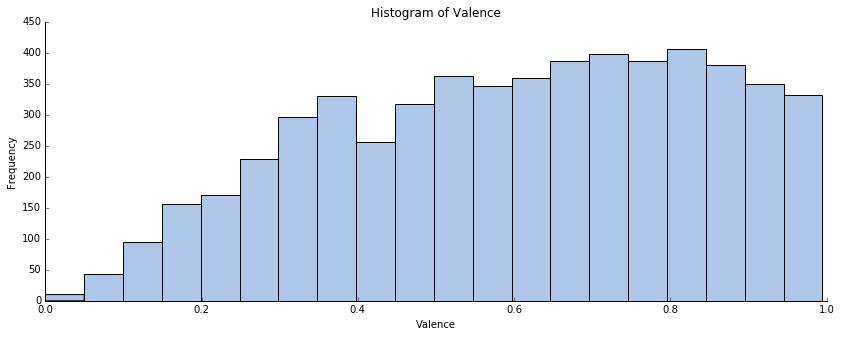

In [9]:
# Plot
plt.figure(figsize=(14, 5))
plt.xlabel('Valence')
plt.ylabel('Frequency')
plt.title('Histogram of Valence')
plt.grid(False)

# Remove the plot frame lines
ax = plt.subplot(111)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Ensure that the axis ticks only show up on the bottom and left of the plot.
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

# Histogram of the valence data
n, bins, patches = plt.hist(valence_cleaned.values, normed = False, color = COLORS[1], bins = 20)

plt.show()

The distribution does not seem to be normal. We observe a plateau for 0.6 <= valence <= 0.85. The population presents less variance than a normal distribution. To illustrate those words, we will use a **probability plot**:

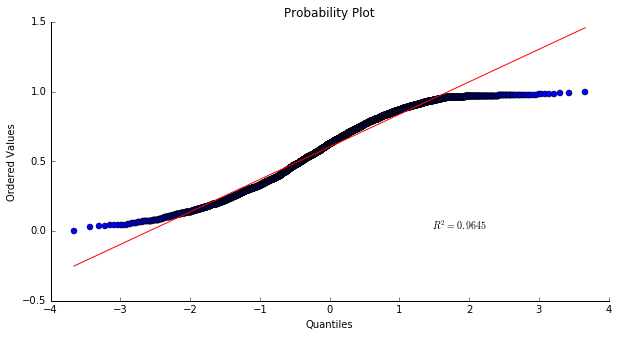

In [10]:
# Plot
plt.figure(figsize=(10, 5))
plt.grid(False)

# Remove the plot frame lines
ax = plt.subplot(111)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Ensure that the axis ticks only show up on the bottom and left of the plot.
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

# Probability plot
res = stats.probplot(valence_cleaned, dist = "norm", plot = plt)

plt.show()

This S shaped-curve indicates shorter than normal tails, i.e. less variance than expected. This confirms that the valence of the tracks is not normally distributed.

Using the `describe` command, we are going to plot some interesting statistic figures about the valence data:

In [11]:
valence_cleaned.describe()

count    5608.000000
mean        0.603195
std         0.237206
min         0.000000
25%         0.413064
50%         0.624989
75%         0.803726
max         0.994769
Name: valence, dtype: float64

As a result, we have a mean value of approximatively 0.6 for the valence. Plus, as the median is equal to 0.625, there are as many tracks having a valence included between 0 and 0.625 and tracks having a valence included between 0.625 and 1. This means that globally the songs  of the *Billboard* Hot 100 sound **positive**.

Is it the same thing for each decade?

In [12]:
reload(dsf)

<module 'dataStoryFunctions' from 'dataStoryFunctions.pyc'>

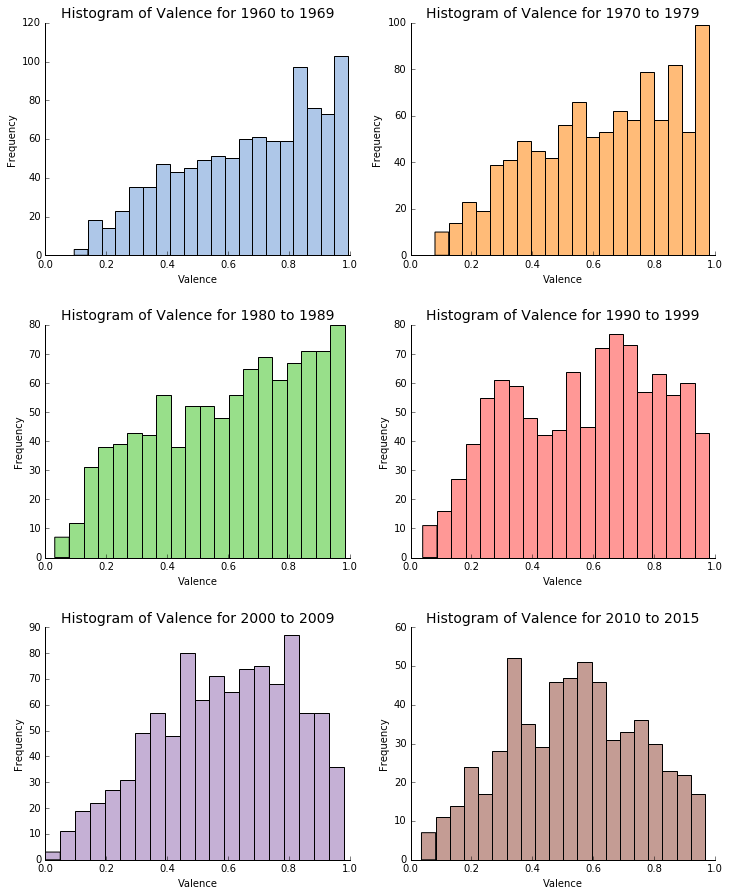

In [41]:
dsf.create_valence_histogram_per_decade(billboard_df_final)

In [14]:
valence_dict, valence_dict_description = dsf.get_valence_by_decade(billboard_df_final)

According to the previous series of histograms, it seems that the distribution of the valence is changing over the time, even if the mean and the median of the population do not change a lot.

##### Energy

Before combining the energy and valence, let's have a look at the energy distribution in our dataset.

In [24]:
energy_cleaned = billboard_df_final["energy"].dropna()

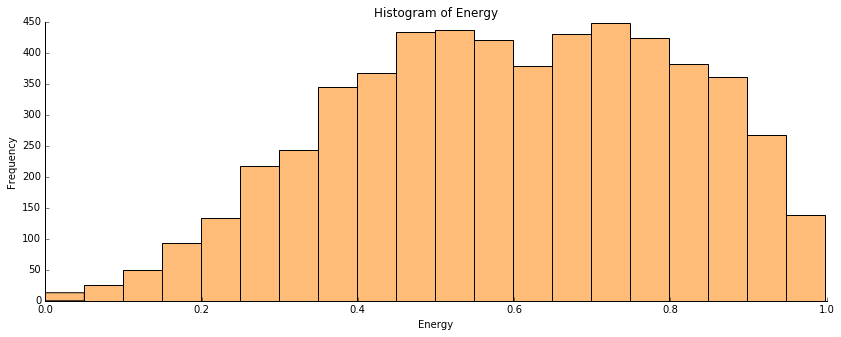

In [58]:
# Plot
plt.figure(figsize=(14, 5))
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.title('Histogram of Energy')
plt.grid(False)

# Remove the plot frame lines
ax = plt.subplot(111)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Ensure that the axis ticks only show up on the bottom and left of the plot.
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

# Histogram of the energy data
n, bins, patches = plt.hist(energy_cleaned.values, normed = False, color = COLORS[3], bins = 20)

plt.show()

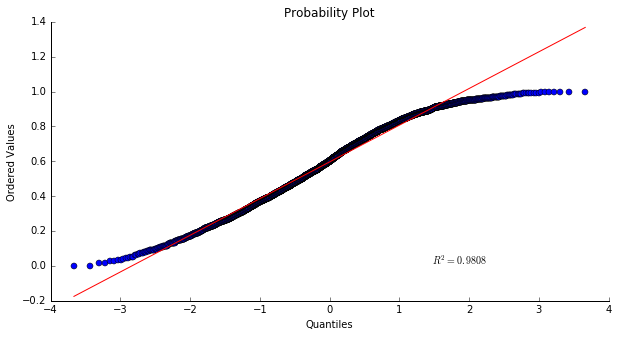

In [28]:
# Plot
plt.figure(figsize=(10, 5))
plt.grid(False)

# Remove the plot frame lines
ax = plt.subplot(111)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Ensure that the axis ticks only show up on the bottom and left of the plot.
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

# Probability plot
res = stats.probplot(energy_cleaned, dist = "norm", plot = plt)

plt.show()

In [29]:
energy_cleaned.describe()

count    5609.000000
mean        0.596539
std         0.212346
min         0.000020
25%         0.438360
50%         0.601786
75%         0.769029
max         0.998143
Name: energy, dtype: float64

The conclusion regarding the distribution of the energy feature on the global data is similar to the one made for the valence. The distribution is not normal, we have a short tail ditribution. 

Let's have a look at the different distributions by decade:

In [37]:
reload(dsf)

<module 'dataStoryFunctions' from 'dataStoryFunctions.py'>

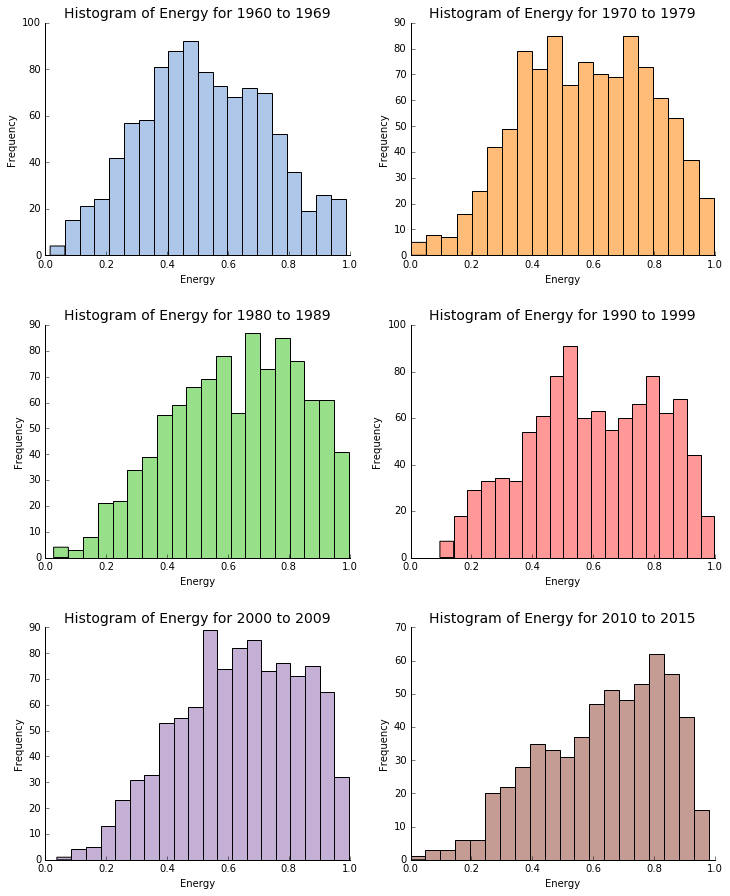

In [39]:
dsf.create_energy_histogram_per_decade(billboard_df_final)

I will know combine the energy and the valence to have an better estimation of the **musical mood** of the different tracks of my dataset. The idea is to represent this relation grpahically using a scatter plot. On the x-axis we will have the valence of each track, on the y-axis the energy and the color of each circle will correspond to the decade in which the song has been released.

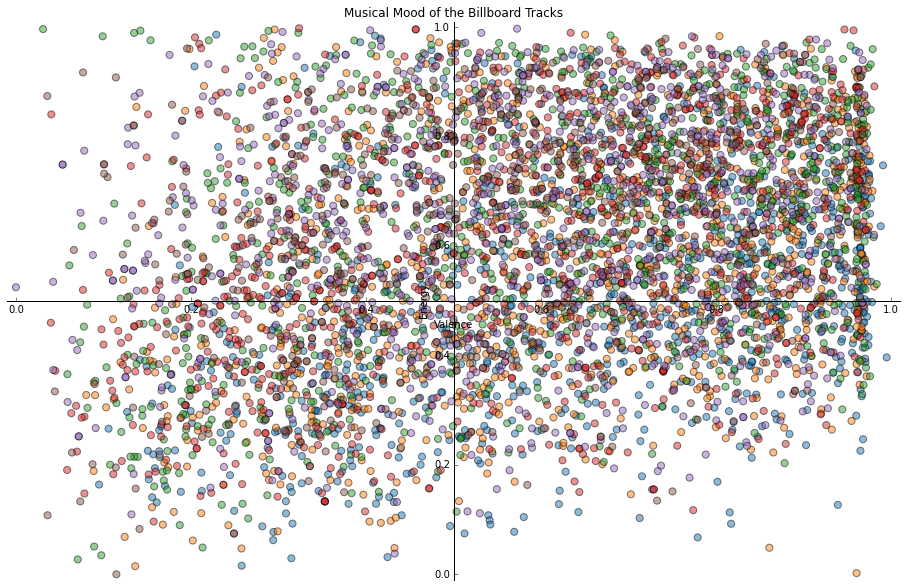

In [21]:
dsf.prepare_data_for_valence_vs_energy_scatter_plot(billboard_df_final)

###### Best songs of all time

In [514]:
best_songs_of_all_time_1 = [
    {'artist': 'Queen', 'title': 'Bohemian Rhapsody', 'year': 1975},
    {'artist': 'Led Zeppelin', 'title': 'Stairway to Heaven', 'year': 1971},
    {'artist': 'John Lennon', 'title': 'Imagine', 'year': 1971},
    {'artist': 'Nirvana', 'title': 'Smells like teen spirit', 'year': 1991},
    {'artist': 'Eagles', 'title': 'Hotel California', 'year': 1976},
    {'artist': "Guns N' Roses", 'title': "Sweet Child O' Mine", 'year': 1987},
    {'artist': 'Metallica', 'title': 'One', 'year': 1989},
    {'artist': 'Pink Floyd', 'title': 'Comfortably Numb', 'year': 1979},
    {'artist': 'Bob Dylan', 'title': 'Like a Rolling Stone', 'year': 1965},
    {'artist': 'The Beatles', 'title': 'Hey Jude', 'year': 1968}
]

In [520]:
reload(dsf)

<module 'dataStoryFunctions' from 'dataStoryFunctions.py'>

In [521]:
# Builds the best songs of all time dataframe and clean the billboard df
best_songs_of_all_time_df, billboard_df_final_cleaned = dsf.create_best_songs_of_all_time_df(best_songs_of_all_time_1, 
                                                                                last_fm_network, billboard_df_final)

In [522]:
# Performs the similarity search and append the new values to the data frame
best_songs_of_all_time_df = dsf.find_similar_songs(best_songs_of_all_time_df, 
                                                   billboard_df_final_cleaned, ['valence', 'energy'])

In [523]:
best_songs_of_all_time_df.to_csv('CSV_data/best_songs_of_all_time.csv', sep=',')  

In [524]:
best_songs_of_all_time_df

,artist,title,year,danceability,energy,loudness,tempo,valence,image_url,in_billboard,...,valence similar song 4,energy similar song 4,year similar song 4,distance 4,similar artist 5,similar song 5,valence similar song 5,energy similar song 5,year similar song 5,distance 5
0,Queen,Bohemian Rhapsody,1975,0.379808,0.163675,-22.19,71.337,0.237069,http://img2-ak.lst.fm/i/u/300x300/43871b6b40f1...,Yes,...,0.258436,0.164848,1997,0.0213992,The Impressions,I'm So Proud,0.212373,0.152397,1964,0.027149
1,Led Zeppelin,Stairway to Heaven,1971,0.338102,0.339565,-12.049,82.433,0.205086,http://img2-ak.lst.fm/i/u/300x300/1e6f99756d03...,No,...,0.199533,0.338692,1989,0.0056212,Billy Preston and Syreeta,With You I'm Born Again,0.196757,0.336987,1980,0.008719
2,John Lennon,Imagine,1971,0.289874,0.406118,-11.824,145.095,0.256124,http://img2-ak.lst.fm/i/u/300x300/419d5500087d...,No,...,0.270559,0.406326,1962,0.0144365,James Taylor,You've Got a Friend,0.271840,0.402646,1971,0.016095
3,Nirvana,Smells like teen spirit,1991,0.452536,0.871809,-10.327,126.188,0.596938,http://img2-ak.lst.fm/i/u/300x300/fb27b5245fb7...,No,...,0.597715,0.859518,1999,0.0123155,Katy Perry featuring Juicy J,Dark Horse,0.598704,0.884505,2014,0.012818
4,Eagles,Hotel California,1976,0.579199,0.516623,-10.566,147.723,0.644652,http://img2-ak.lst.fm/i/u/300x300/ec559161068a...,Yes,...,0.65222,0.521928,2003,0.00924217,Natural Selection,Do Anything,0.655680,0.515493,1991,0.011086
5,Guns N' Roses,Sweet Child O' Mine,1987,0.703259,0.634488,-8.574,134.74,0.754677,http://img2-ak.lst.fm/i/u/300x300/eed51418bdbc...,No,...,0.742384,0.631048,2009,0.0127652,Jay Sean featuring Lil Wayne,Down,0.742384,0.631048,2010,0.012765
6,Metallica,One,1989,0.413753,0.843551,-7.582,103.763,0.427163,http://img2-ak.lst.fm/i/u/300x300/55bf2f31f75a...,No,...,0.428515,0.833365,2011,0.0102753,Janet Jackson,Escapade,0.426047,0.833177,1990,0.010434
7,Pink Floyd,Comfortably Numb,1979,0.454179,0.413954,-19.571,108.446,0.450844,http://img2-ak.lst.fm/i/u/300x300/6af6a9a0d246...,No,...,0.457767,0.417739,1996,0.00789013,The Cover Girls,We Can't Go Wrong,0.461430,0.409259,1990,0.011580
8,Bob Dylan,Like a Rolling Stone,1965,0.118945,0.938624,-6.956,174.962,0.159969,http://img2-ak.lst.fm/i/u/300x300/c2312403b76a...,Yes,...,0.198271,0.960211,1970,0.0439664,Joey Dee and the Starliters,Shout,0.203999,0.928512,1962,0.045176
9,The Beatles,Hey Jude,1968,0.464355,0.462577,-10.116,148.127,0.527583,http://img2-ak.lst.fm/i/u/300x300/c287f9f43329...,Yes,...,0.535306,0.470792,1975,0.0112752,Olivia Newton-John,Have You Never Been Mellow,0.532448,0.475778,1975,0.014069


###### TODO

* Hypothesis testing: suppose we want to build a random playlist of X songs from the Billboard charts, what is the probability that the valence of the playlist will be > 0.5
* Combine 'energy' and 'valence' to have an understanding of the musical mood of the songs (scatter plot with color for each decade) => introduction of a new feature
* Distinction between Major and Minor songs (eventually add the key of the song) as in general major songs are 'happier' than minors songs. Cross check that with the previous study (musical mood).
* Look how to the best songs of all time can be classified ?????
* Combine the study of the musical mood with a sentiment analysis on the lyrics of the song to see if the two values are correlated (interesting but long
* Correlations between the variables: especially the danceability because I think that this variable can be explained using other features like the tempo, loudness, energy, etc... => build a regression linear model + see if the danceability is an important feature
* Similarity between artists (k-nearest neighbors / k-means)

In [525]:
results = song.search(artist = 'Renaud', title = 'Mistral Gagnant', 
                                    buckets=[ 'audio_summary', 'song_type', 'song_discovery'])

In [526]:
results

[<song - Mistral gagnant>,
 <song - Mistral gagnant>,
 <song - Mistral Gagnant (Live)>,
 <song - Mistral Gagnant (Live)>,
 <song - Mistral Gagnant (Live Tournée Rouge Sang)>]

###### Temp

Trying different methods to have the valence data normally distributed

(array([-20.        , -19.49367089, -18.98734177, -18.48101266,
        -17.97468354, -17.46835443, -16.96202532, -16.4556962 ,
        -15.94936709, -15.44303797, -14.93670886, -14.43037975,
        -13.92405063, -13.41772152, -12.91139241, -12.40506329,
        -11.89873418, -11.39240506, -10.88607595, -10.37974684,
         -9.87341772,  -9.36708861,  -8.86075949,  -8.35443038,
         -7.84810127,  -7.34177215,  -6.83544304,  -6.32911392,
         -5.82278481,  -5.3164557 ,  -4.81012658,  -4.30379747,
         -3.79746835,  -3.29113924,  -2.78481013,  -2.27848101,
         -1.7721519 ,  -1.26582278,  -0.75949367,  -0.25316456,
          0.25316456,   0.75949367,   1.26582278,   1.7721519 ,
          2.27848101,   2.78481013,   3.29113924,   3.79746835,
          4.30379747,   4.81012658,   5.3164557 ,   5.82278481,
          6.32911392,   6.83544304,   7.34177215,   7.84810127,
          8.35443038,   8.86075949,   9.36708861,   9.87341772,
         10.37974684,  10.88607595,  11.

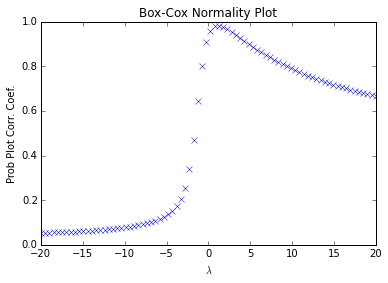

In [58]:
prob = stats.boxcox_normplot(subset_valence.dropna(), -20, 20, plot=plt)
prob

In [38]:
subset_valence = billboard_df_final[billboard_df_final["valence"] > 0]["valence"]
test_valence = subset_valence.dropna().map(lambda x: log(x))

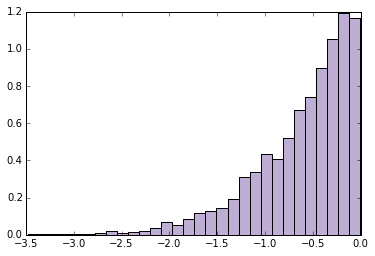

In [39]:
n, bins, patches = plt.hist(test_valence, normed = True, 
                            color = COLOR2, bins = 30)

In [59]:
boxcox, maxlog = stats.boxcox(subset_valence.dropna())
maxlog

1.0851936512647853

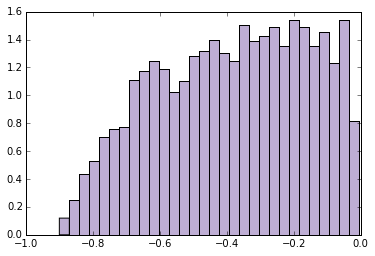

In [45]:
n, bins, patches = plt.hist(boxcox, normed = True, 
                            color = COLOR2, bins = 30)

In [46]:
subset_valence.head()

0    0.833641
1    0.158728
2    0.575020
3    0.815120
4    0.281412
Name: valence, dtype: float64

In [18]:
sample = np.random.choice(valence_cleaned, 100)

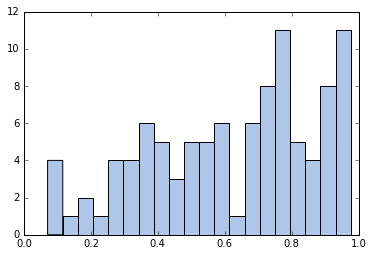

In [19]:
n, bins, patches = plt.hist(sample, normed = False, color = COLORS[1], bins = 20)

In [45]:
def make_sample(n=100):
    sample = valence_cleaned.rvs(n)
    return sample

In [116]:
artist_object = last_fm_network.get_artist('Maria Carey')
image_url = artist_object.get_cover_image()

In [117]:
image_url

u'http://img2-ak.lst.fm/i/u/7d4f77a932c2409b8cf77fec491b2059.png'